# Home Assignment No. 3: Part 1 

In this part of the homework you are to solve several problems related to machine learning algorithms.
* For every separate problem you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**.
* Your solution must me **COMPLETE**, i.e. contain all required formulas/proofs/detailed explanations.
* You must write your solution for any problem just right after the words **BEGIN SOLUTION**. Attaching pictures of your handwriting is allowed, but **highly discouraged**.
* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` library instead of writing tons of our yown code. There exists a class/method for almost everything you can imagine (related to this homework).
* To do some tasks in this part of homework, you have to write **CODE** directly inside specified places inside notebook **CELLS**.
* In some problems you may be asked to provide short discussion of the results. In this cases you have to create **MARKDOWN** cell with your comments right after the your code cell.
* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if the reviewer decides to execute `Kernel` -> `Restart Kernel and Run All Cells`, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include neccessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.
* The are problems with \* mark - they are not obligatory. You can get **EXTRA POINTS** for solving them.
## $\LaTeX$ in Jupyter
Jupyter has constantly improving $\LaTeX$ support. Below are the basic methods to
write **neat, tidy, and well typeset** equations in your notebooks:
* to write an **inline** equation use 
```markdown
$ you latex equation here $
```
* to write an equation, that is **displayed on a separate line** use 
```markdown
$$ you latex equation here $$
```
* to write a **block of equations** use 
```markdown
\begin{align}
    left-hand-side
        &= right-hand-side on line 1
        \\
        &= right-hand-side on line 2
        \\
        &= right-hand-side on the last line
\end{align}
```
The **ampersand** (`&`) aligns the equations horizontally and the **double backslash**
(`\\`) creates a new line.

Write your theoretical derivations within such blocks:
```markdown
**BEGIN Solution**

<!-- >>> your derivation here <<< -->

**END Solution**
```

Please, write your implementation within the designated blocks:
```python
...
### BEGIN Solution

# >>> your solution here <<<

### END Solution
...
```


<br>

In [2]:
import numpy as np
import pandas as pd

import torch

%matplotlib inline
import matplotlib.pyplot as plt

<br>

# Bayesian Models. GLM

## Task 1 (1 pt.)

Consider a univariate Gaussian distribution $\mathcal{N}(x; \mu, \tau^{-1})$.
Let's define Gaussian-Gamma prior for parameters $(\mu, \tau)$:

\begin{equation}
    p(\mu, \tau)
        = \mathcal{N}(\mu; \mu_0, (\beta \tau)^{-1})
            \otimes \text{Gamma}(\tau; a, b)
        \,.
\end{equation}

Find the posterior distribution of $(\mu, \tau)$ after observing $X = (x_1, \dots, x_n)$.

**BEGIN Solution**

$$
\mathbb{P}(\mu, \tau | X) = \frac{ p(\mu, \tau) \mathbb{P}(X | \mu, \tau) } {\mathbb{P}(X)}
$$ By condition:
$$
\mathbb{P}(X | \mu, \tau) = \prod_{i=1}^n \mathbb{P}(x_i | \mu, \tau) $$
As we know distribution of each datasample:
$$ \mathbb{P}(X | \mu, \tau) = \prod_{i=1}^n \frac{\tau^{\frac{1}{2}}}{\sqrt{2 \pi}} \exp{ \Big[-\frac{\tau (x_i - \mu)^2 }{2}\Big]} = 
\frac{\tau^{\frac{1}{2}}}{\sqrt{2 \pi}} \exp{ \Big[-\frac{\tau}{2} \sum_{i=1}^n(x_i - \mu)^2 \Big]} $$

After substitution:
$$
\boxed {\mathbb{P}(\mu, \tau | X)
=
\frac{\mathcal{N}(\mu; \mu_0, (\beta \tau)^{-1}) \otimes \text{Gamma}(\tau; a, b)
\cdot \frac{\tau^{\frac{1}{2}}}{\sqrt{2 \pi}} \exp{ \Big[-\frac{\tau}{2} \sum_{i=1}^n(x_i - \mu)^2 \Big]}}{\mathbb{P}(X)}}
$$

**END Solution**

<br>

## Task 2 (1 + 1 + 1 = 3 pt.)

Evaluate the following integral using the Laplace approximation:
\begin{equation}
    x \mapsto \int \sigma(w^T x) \mathcal{N}(w; 0, \Sigma) dw \,,
\end{equation}
for $x = \bigl(\tfrac23, \tfrac16, \tfrac16\bigr)\in \mathbb{R}^3$ and 
\begin{equation}
    \Sigma
        = \begin{pmatrix}
             1    & -0.25 & 0.75 \\
            -0.25 &  1    & 0.5  \\
             0.75 &  0.5  & 2
           \end{pmatrix}
        \,.
\end{equation}

### Task 2.1 (1 pt.)
Use the Hessian matrix computed numericaly via finite differences. (Check out [Numdifftools](https://pypi.python.org/pypi/Numdifftools))

In [17]:
import numdifftools as nd
from scipy.optimize import minimize
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [82]:
### BEGIN Solution

def p_star_w(w):
    x = np.array([2/3, 1/6, 1/6], dtype=np.float64)
    E = np.array([[1, -0.25, 0.75], [-0.25, 1, 0.5], [0.75, 0.5, 2]], dtype=np.float64)
    left_part = 1/(1+np.exp(- w.T @ x))
    right_part = multivariate_normal(mean=[0,0,0], cov=E).pdf(w)
    return left_part * right_part

def log_star_w(w):
    return -np.log(p_star_w(w))

w_0 = minimize(log_star_w, np.array([1,2,1], dtype=np.float64)).x
Hessian = nd.Hessian(log_star_w)
A = Hessian(w_0)
Z_p = p_star_w(w_0) * np.sqrt((2*np.pi)**3/np.linalg.det(A))

print("The value of intergral:", Z_p)

### END Solution

The value of intergral: 0.49791972000790274


<br>

### Task 2.2 (1 pt.)
Use the diagonal approximation of the Hessian computed by autodifferentiation
in **pytorch**.

In [31]:
import torch
from torch.autograd import Variable, grad

In [108]:
### BEGIN Solution

def pt_p_star_w(w):
    x = np.array([2/3, 1/6, 1/6], dtype=np.float64)
    E = np.array([[1, -0.25, 0.75], [-0.25, 1, 0.5], [0.75, 0.5, 2]], dtype=np.float64)
    left_part = torch.sigmoid(torch.dot(w, Variable(torch.from_numpy(x).type(torch.FloatTensor))))
    right_part = 1 / (( 2 * np.pi )**(3/2) * np.linalg.det(E)**(1/2)) *\
                 torch.exp(-0.5 * w @ Variable(torch.from_numpy(np.linalg.inv(E)).type(torch.FloatTensor))@w)
    return left_part * right_part

def pt_log_star_w(w):
    return -torch.log(pt_p_star_w(w))

def hessian_diag(func, w):
    w = Variable(torch.FloatTensor(w), requires_grad=True)
    grad_params = torch.autograd.grad(func(w), w, create_graph=True)
    hessian = [torch.autograd.grad(grad_params[0][i], w, create_graph=True)[0].data.numpy() \
               for i in range(3)]
    return np.diagonal(hessian)*np.eye(3)

A = hessian_diag(pt_log_star_w, w_0)

pt_Z_p = (np.sqrt((2*np.pi)**3 / np.linalg.det(A)) *\
       pt_p_star_w(Variable(torch.from_numpy(w_0).type(torch.FloatTensor)))).data.numpy()

print('Integral value is', pt_Z_p)

### END Solution

Integral value is 0.29643095


<br>

### Task 2.3 (1 pt.)

Compare the results comparing the `absolute errors` of the results (this is possible with Monte-Carlo estimate of the integral). Write 1-2 sentences in the results discussion.

In [112]:
from scipy.integrate import tplquad

### BEGIN Solution

def p_star_w_adapter(x, y, z):
    return p_star_w(np.array([x,y,z]))

acc_Z_p = tplquad(p_star_w_adapter, -10, 10, -10, 10, -10, 10)

print("Laplace method: %.05f" % abs(acc_Z_p[0] - Z_p))
print("Diag. Hessian Approx: %.05f" % abs(acc_Z_p[0] - pt_Z_p))

### END Solution

Laplace method: 0.00208
Diag. Hessian Approx: 0.20357


**BEGIN Solution**

So, we have got big absolute error in the second line due to the fact that we used Hessian diagonal approximation which neglects a lot of values off the diagonal

**END Solution**

<br>

# Gaussian Processes

## Task 3 (1 + 2 = 3 pt.)

### Task 3.1 (1 pt.)

Assuimng the matrices $A \in \mathbb{R}^{n \times n}$ and $D \in \mathbb{R}^{d \times d}$
are invertible, using **gaussian elimination** find the inverse matrix for the following
block matrix:
\begin{equation}
    \begin{pmatrix} A & B \\ C & D \end{pmatrix} \,,
\end{equation}
where $C \in \mathbb{R}^{d \times n}$ and $B \in \mathbb{R}^{n \times d}$.

**BEGIN Solution**

**END Solution**

<br>

### Task 3.2 (2 pt.)

Assume that the function $y(x)$, $x \in \mathbb{R}^d$, is a realization of the Gaussian
Process $GP\bigl(0; K(\cdot, \cdot)\bigr)$ with $K(a, b) = \exp({- \gamma \|a - b\|_2^2}))$.

Suppose two datasets were observed: **noiseless** ${D_0}$ and **noisy** ${D_1}$
\begin{aligned}
    & D_0 = \bigl(x_i, y(x_i) \bigr)_{i=1}^{n} \,, \\
    & D_1 = \bigl(x^\prime_i, y(x^\prime_i) + \varepsilon_i \bigr)_{i=1}^{m} \,,
\end{aligned}
where $\varepsilon_i \sim \text{ iid } \mathcal{N}(0, \sigma^2)$, independent of process $y$.

Derive the conditional distribution of $y(x) \big\vert_{D_0, D_1}$ at a new $x$.

**BEGIN Solution**

**END Solution**

<br>

## Task 4 (1 + 2 = 3 pt.)

### Task 4.1 (1 pt.)

> In the late 1950’s Charles Keeling invented an accurate way to measure atmospheric $CO_2$ concentration and began taking regular measurements at the Mauna Loa observatory.


Take `monthly_co2_mlo.csv` file, load it and prepare the data.

0. Load the `CO2 [ppm]` time series
1. Replace $-99.99$ with **NaN** and drop the missing observations
2. Split the time series into train and test
3. Normalize the target value by fitting a transformation on the train
4. Plot the resulting target against the time index

In [141]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### BEGIN Solution

df = pd.read_csv('data/monthly_co2_mlo.csv')
df = df.replace(-99.99, np.nan).dropna()
df.head(10)
y = df['CO2 [ppm]']
X = df.drop(['CO2 [ppm]'], axis=1)
X['year'] -= 1958
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=False, test_size=0.25)
X.head(10)
### END Solution

,year,seasonally adjusted [ppm],fit [ppm],seasonally adjusted fit [ppm],CO2 filled [ppm],seasonally adjusted filled [ppm]
2,0.166667,314.43,316.19,314.90,315.70,314.43
3,0.250000,315.15,317.30,314.98,317.45,315.15
4,0.333333,314.72,317.85,315.06,317.51,314.72
6,0.500000,315.18,315.87,315.22,315.86,315.18
7,0.583333,316.18,314.00,315.29,314.93,316.18
8,0.666667,316.08,312.46,315.35,313.21,316.08
10,0.833333,315.20,313.62,315.46,313.33,315.20
11,0.916667,315.43,314.77,315.52,314.67,315.43
12,1.000000,315.55,315.61,315.57,315.58,315.55
13,1.083333,315.87,316.26,315.64,316.48,315.87


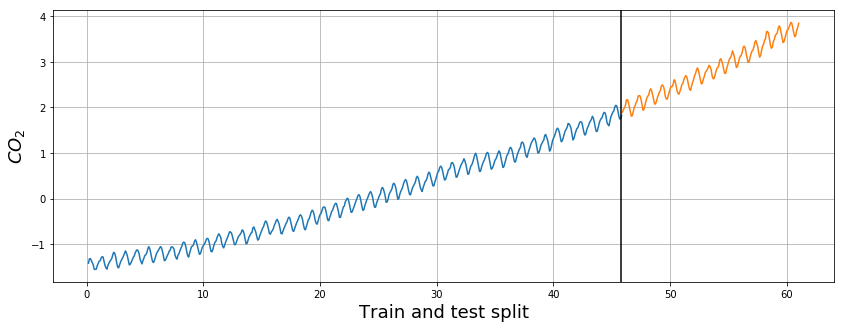

In [161]:
scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

plt.figure(figsize=(14, 5))
plt.plot(X_train['year'],  y_train_scaled)
plt.plot(X_test['year'],  y_test_scaled)
plt.axvline(x=0.75 * np.max([np.max(X_train['year'].values), np.max(X_test['year'].values)]), c='black', ls='-')
plt.grid()
plt.ylabel(r'${CO}_2$', size=18)
plt.xlabel('Train and test split', size=18)
plt.show()

<br>

### Task 4.2 (2 pt.)

Use [**GPy**](https://pypi.python.org/pypi/GPy) library for training and prediction. Fit a GP and run the predict on the test. Useful kernels to combine: `GPy.kern.RBF, GPy.kern.Poly, GPy.kern.StdPeriodic, GPy.kern.White, GPy.kern.Linear`. 

1. Plot mean and confidence interval of the prediction. 
2. Inspect them on normality by scatter plot: plot predicted points/time series against true values. 
3. Estimate the prediction error with `r2_score`. R2-score accepted > 0.83 on test sample.

In [162]:
from GPy.models import GPRegression
from GPy.kern import RBF, Poly, StdPeriodic, White, Linear
from sklearn.metrics import r2_score

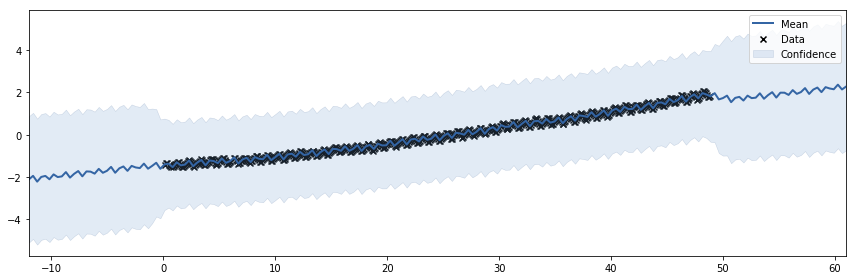

In [52]:
### BEGIN Solution

### END Solution

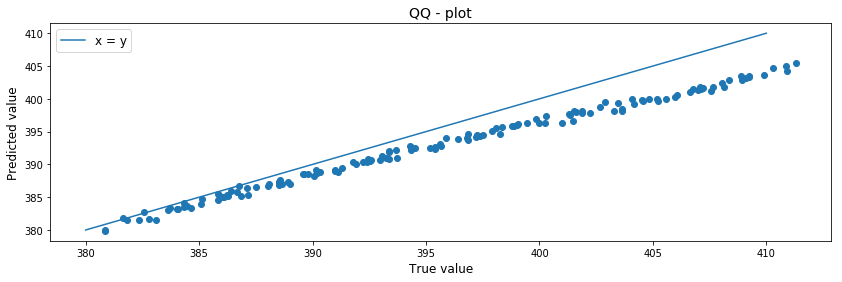

In [58]:
# >>> your code here <<<

In [61]:
r2_score(# >>> your code here <<<)

0.839219217819017